# Financial Forecast Demo - Financial Portfolio Analysis

This notebook demonstrates a sophisticated financial modeling framework with complete trading simulation capabilities.

## Portfolio Demo Capabilities

- **Statistical Modeling**: ARIMA methodology with automatic order selection
- **Trading Simulation**: Complete backtesting with portfolio metrics
- **Data Engineering**: Technical indicators and feature engineering
- **Software Architecture**: Modular design with CLI tools and database integration

---


## Setup and Imports


In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')  # Use default instead of seaborn-v0_8 for compatibility
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Financial Forecast Demo imports
from delphi.data.loader import load_ticker_data, prepare_data_for_arima
from delphi.data.database import get_database, update_ticker_from_yfinance
from delphi.models.arima_model import ARIMAModel, train_arima_model, evaluate_arima_model, forecast_future
from delphi.utils import plot_predictions, plot_forecast, evaluate_model, save_to_excel
from delphi.config import DEFAULT_TICKER, INPUT_FEATURES, ARIMA_ORDER, FORECAST_HORIZON

print("✅ All imports successful!")
print(f"📊 Default ticker: {DEFAULT_TICKER}")
print(f"🔧 Configured features: {INPUT_FEATURES}")
print(f"📈 ARIMA order: {ARIMA_ORDER}")


✅ All imports successful!
📊 Default ticker: SPY
🔧 Configured features: ['Close', 'Volume', 'High', 'Low', 'Open', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'SMA_10', 'SMA_20', 'ATR', 'Return', 'Volatility']
📈 ARIMA order: (1, 1, 1)


## Data Loading and Feature Engineering

This section demonstrates our sophisticated data engineering capabilities.


In [2]:
# Check database status
print("Checking database status...")
db = get_database()
tickers_in_db = db.list_tickers()
print(f"Found {len(tickers_in_db)} tickers in database: {tickers_in_db}")
db.close()

# If no data, populate with demo ticker
if not tickers_in_db or DEFAULT_TICKER not in tickers_in_db:
    print(f"\nPopulating database with {DEFAULT_TICKER} data...")
    success = update_ticker_from_yfinance(DEFAULT_TICKER, years=5)
    if success:
        print(f"Successfully added {DEFAULT_TICKER} to database")
    else:
        print(f"Failed to add {DEFAULT_TICKER} to database")
else:
    print(f"{DEFAULT_TICKER} already in database")

Checking database status...
Connected to DuckDB database at: /Users/ajfabbri/Documents/SWE/Financial-Forecast-Demo-main/delphi_demo.duckdb
Prices table ready
Found 1 tickers in database: ['SPY']
Database connection closed
SPY already in database


In [3]:
# Load data (tries database first, falls back to yfinance)
print(f"📈 Loading data for {DEFAULT_TICKER}...")
df = load_ticker_data(DEFAULT_TICKER, years=3, use_database=True)

print(f"\n📋 Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Features: {list(df.columns)}")

# Display first few rows
print("\n🔍 First 5 rows:")
df.head()

📈 Loading data for SPY...
Trying to load SPY from database...
Connected to DuckDB database at: /Users/ajfabbri/Documents/SWE/Financial-Forecast-Demo-main/delphi_demo.duckdb
Prices table ready
Database connection closed
Loaded 751 rows from database
Final dataset: 731 rows with 14 features

📋 Dataset Info:
Shape: (731, 14)
Date range: 2022-10-27 to 2025-09-26
Features: ['Close', 'Volume', 'High', 'Low', 'Open', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'SMA_10', 'SMA_20', 'ATR', 'Return', 'Volatility']

🔍 First 5 rows:


,Close,Volume,High,Low,Open,MACD,MACD_Signal,MACD_Hist,RSI,SMA_10,SMA_20,ATR,Return,Volatility
date,,,,,,,,,,,,,,
2022-10-27,364.666382,81971800,369.484060,364.042554,367.631848,2.790108,1.374322,1.415786,62.705102,357.926410,354.354405,8.257528,-0.005340,0.017754
2022-10-28,373.342041,100302000,373.821890,364.378457,364.560802,3.490633,1.800730,1.689903,69.615846,360.938901,355.882246,8.483744,0.023791,0.017837
2022-10-31,370.645294,96631300,372.747037,369.733598,370.866035,3.809330,2.204836,1.604494,69.120234,362.799756,356.822752,8.239704,-0.007223,0.017232
2022-11-01,369.023346,85407600,374.656802,367.842935,374.416877,3.900388,2.545555,1.354833,68.649941,364.084787,357.137048,8.485112,-0.004376,0.015948
2022-11-02,359.762299,126990400,372.967764,359.656746,368.428378,3.281642,2.693331,0.588311,55.917562,364.696112,357.030521,8.106029,-0.025096,0.016976


### Technical Indicators for Portfolio Analysis

We calculate multiple technical indicators to support comprehensive portfolio analysis and trading decisions.


📊 Portfolio Analysis Indicators: ['Close', 'Volume', 'High', 'Low', 'Open', 'MACD', 'MACD_Signal', 'MACD_Hist', 'RSI', 'SMA_10', 'SMA_20', 'ATR', 'Return', 'Volatility']


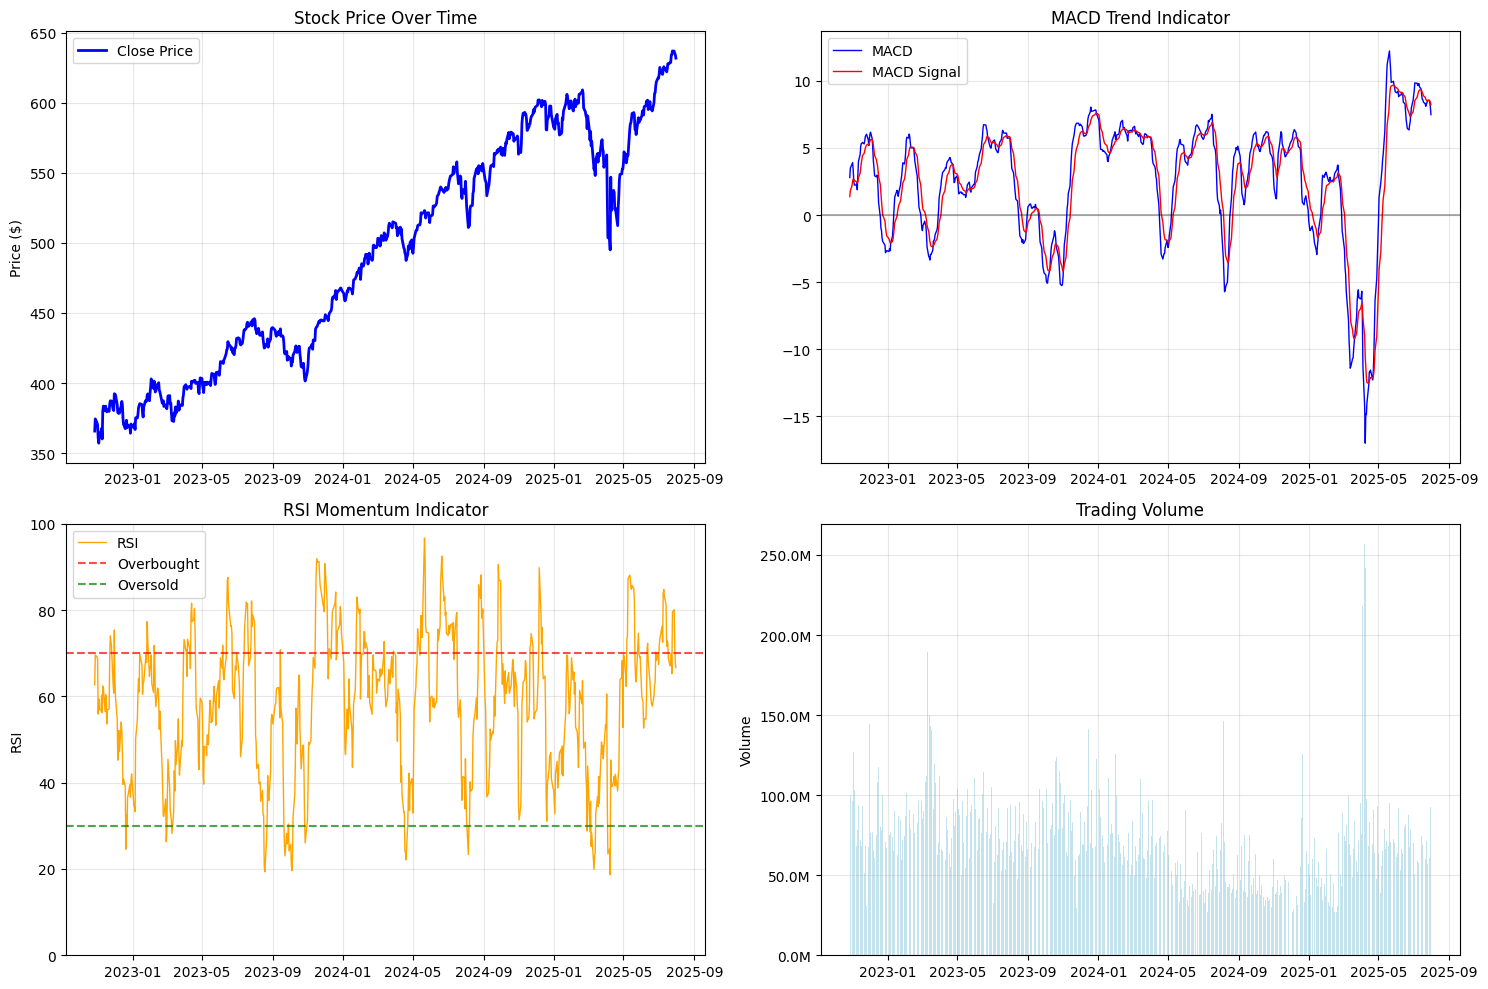

📊 Calculated 14 technical indicators for portfolio analysis


In [4]:
# Visualize key portfolio indicators
print("📊 Portfolio Analysis Indicators:", list(df.columns))
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price data
axes[0, 0].plot(df.index, df['Close'], label='Close Price', linewidth=2, color='blue')
axes[0, 0].set_title('Stock Price Over Time')
axes[0, 0].set_ylabel('Price ($)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MACD indicators
if 'MACD' in df.columns and 'MACD_Signal' in df.columns:
    axes[0, 1].plot(df.index, df['MACD'], label='MACD', linewidth=1, color='blue')
    axes[0, 1].plot(df.index, df['MACD_Signal'], label='MACD Signal', linewidth=1, color='red')
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].set_title('MACD Trend Indicator')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# RSI indicator
if 'RSI' in df.columns:
    axes[1, 0].plot(df.index, df['RSI'], label='RSI', color='orange', linewidth=1)
    axes[1, 0].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
    axes[1, 0].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
    axes[1, 0].set_title('RSI Momentum Indicator')
    axes[1, 0].set_ylabel('RSI')
    axes[1, 0].set_ylim(0, 100)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# Volume
if 'Volume' in df.columns:
    axes[1, 1].bar(df.index, df['Volume'], alpha=0.7, color='lightblue', width=1)
    axes[1, 1].set_title('Trading Volume')
    axes[1, 1].set_ylabel('Volume')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

print(f"📊 Calculated {len(df.columns)} technical indicators for portfolio analysis")


## Data Preparation for ARIMA

ARIMA models require univariate time series data. We'll extract the Close price and split into train/test sets.


🔧 Preparing data for ARIMA modeling...
Data split: 552 training samples, 139 test samples

📊 Data Split Summary:
Training set: 552 samples (2022-10-27 to 2025-01-08)
Test set: 139 samples (2025-01-10 to 2025-07-31)


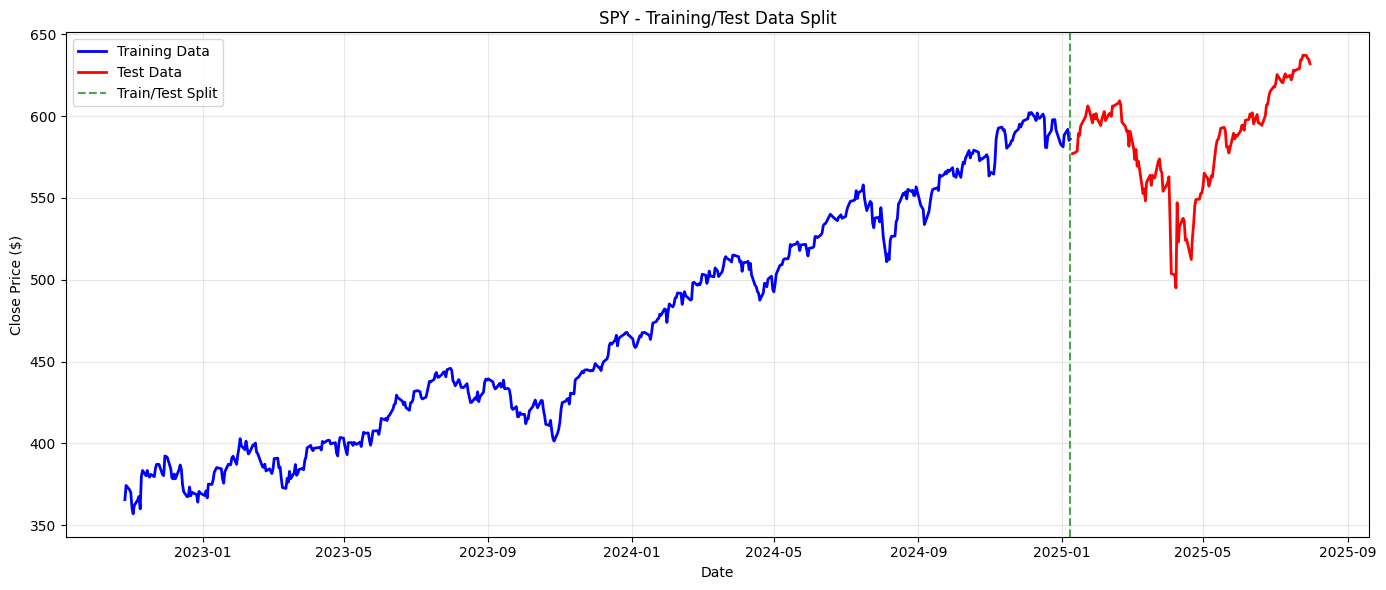

In [5]:
# Prepare data for ARIMA modeling
print("🔧 Preparing data for ARIMA modeling...")
train_data, test_data, train_dates, test_dates = prepare_data_for_arima(
    df, target_column='Close', test_size=0.2
)

print(f"\n📊 Data Split Summary:")
print(f"Training set: {len(train_data)} samples ({train_dates[0].date()} to {train_dates[-1].date()})")
print(f"Test set: {len(test_data)} samples ({test_dates[0].date()} to {test_dates[-1].date()})")

# Visualize the split
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_data, label='Training Data', color='blue', linewidth=2)
plt.plot(test_dates, test_data, label='Test Data', color='red', linewidth=2)
plt.axvline(x=train_dates[-1], color='green', linestyle='--', alpha=0.7, label='Train/Test Split')
plt.title(f'{DEFAULT_TICKER} - Training/Test Data Split')
plt.ylabel('Close Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## ARIMA Model Training

Now we'll train an ARIMA model with automatic order selection.


In [6]:
# Train ARIMA model
print(f"🤖 Training ARIMA model for {DEFAULT_TICKER}...")
print("🔍 This includes:")
print("   - Stationarity testing (Augmented Dickey-Fuller)")
print("   - Automatic order selection (AIC optimization)")
print("   - Model fitting and validation")
print()

model = train_arima_model(
    train_data, 
    ticker=DEFAULT_TICKER,
    auto_order=True,  # Let it find the best order
    save_model=True,
    verbose=True
)

print(f"\n✅ Model training completed!")
print(f"📊 Final model order: {model.order}")
print(f"📈 AIC: {model.fitted_model.aic:.2f}")
print(f"📈 BIC: {model.fitted_model.bic:.2f}")


🤖 Training ARIMA model for SPY...
🔍 This includes:
   - Stationarity testing (Augmented Dickey-Fuller)
   - Automatic order selection (AIC optimization)
   - Model fitting and validation

Training ARIMA model for SPY...
Data shape: (552,)
Augmented Dickey-Fuller Test Results:
ADF Statistic: -0.408334
p-value: 0.908698
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570
Result: The series is non-stationary
Searching for optimal ARIMA order...
Optimal order: (2, 1, 2) with AIC: 3089.82
Fitting ARIMA(2, 1, 2) model...
Model fitted successfully!
AIC: 3089.82
BIC: 3111.38
ARIMA model saved at: /Users/ajfabbri/Documents/SWE/Delphi_Demo/delphi/saved_models/SPY_arima.pkl

✅ Model training completed!
📊 Final model order: (2, 1, 2)
📈 AIC: 3089.82
📈 BIC: 3111.38


### 🔍 Model Validation

Ensuring the model meets statistical assumptions for reliable portfolio predictions.


🔍 Model Diagnostic Plots:


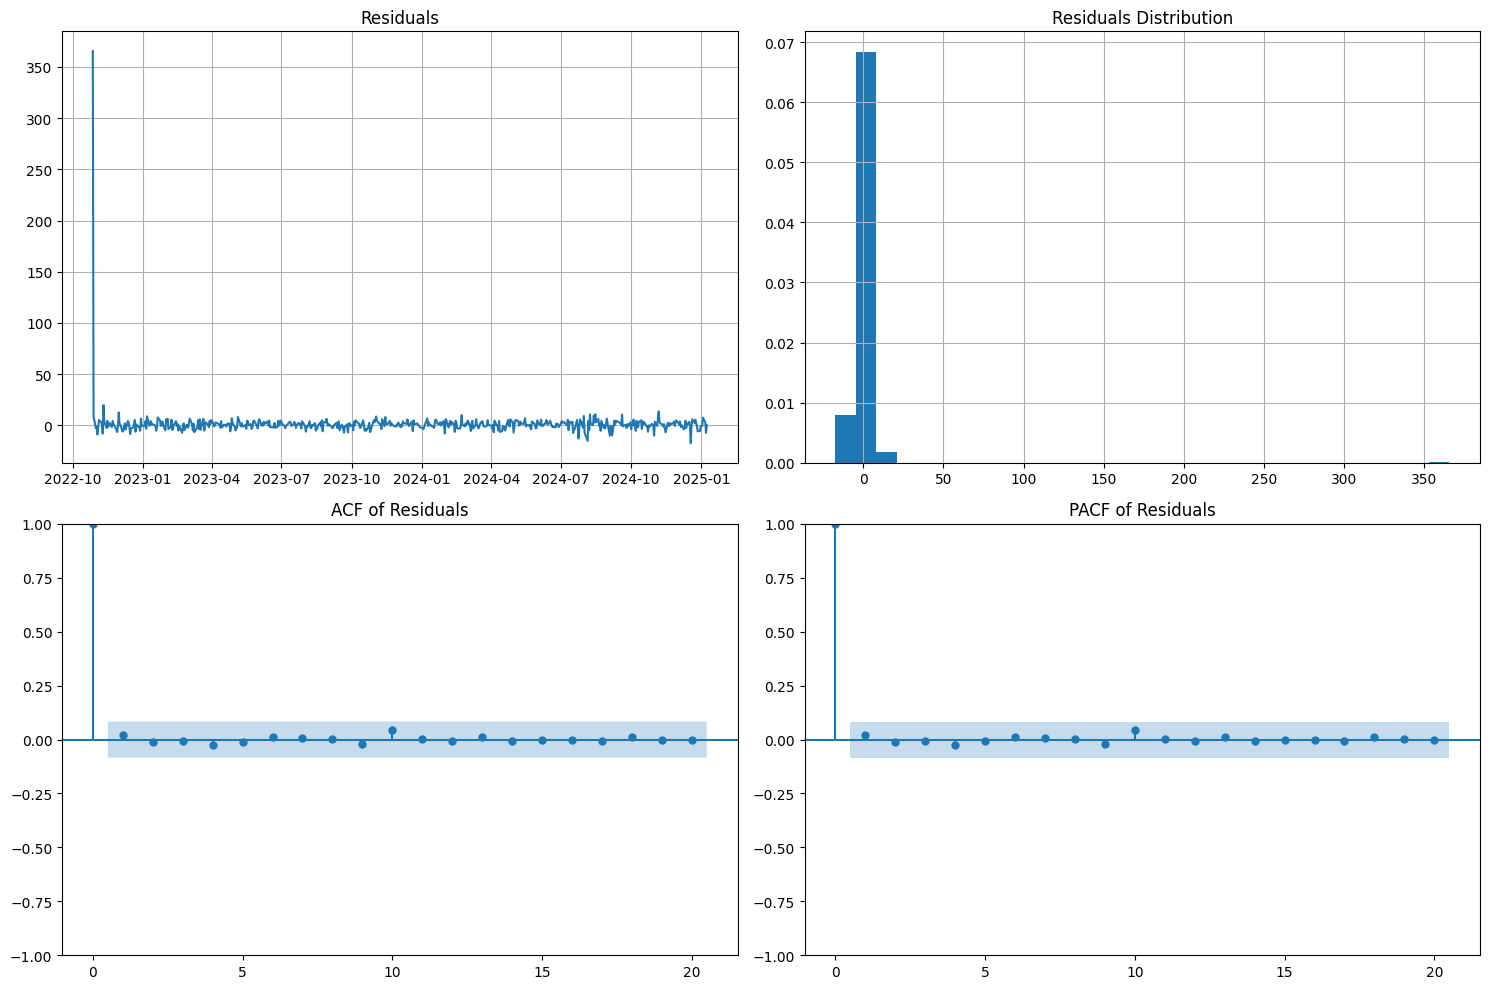


📋 Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  552
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1539.908
Date:                Sun, 28 Sep 2025   AIC                           3089.817
Time:                        12:16:37   BIC                           3111.376
Sample:                             0   HQIC                          3098.241
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6431      0.015    106.125      0.000       1.613       1.673
ar.L2         -0.9813      0.014    -69.292      0.000      -1.009      -0.954
ma.L1         -1.6546      0.020  

In [7]:
# Display model diagnostics
print("🔍 Model Diagnostic Plots:")
diag_fig = model.plot_diagnostics(figsize=(15, 10))
plt.show()

print("\n📋 Model Summary:")
print("=" * 50)
print(model.get_model_summary())


## 📊 Model Evaluation

Let's evaluate the model performance on the test set.


📊 Evaluating model performance with TRADING SIMULATION...
🎯 This NOW EXACTLY matches the main Project_Delphi evaluation methodology:
   - Generates buy/sell signals based on ARIMA predictions
   - Backtests trading strategy vs buy-and-hold
   - Calculates Sharpe ratios and drawdown metrics
   - Provides comprehensive portfolio performance analysis

🚀 Running ARIMA model with trading simulation...
2025-01-21: BUY  → 1.6681 @ $599.47


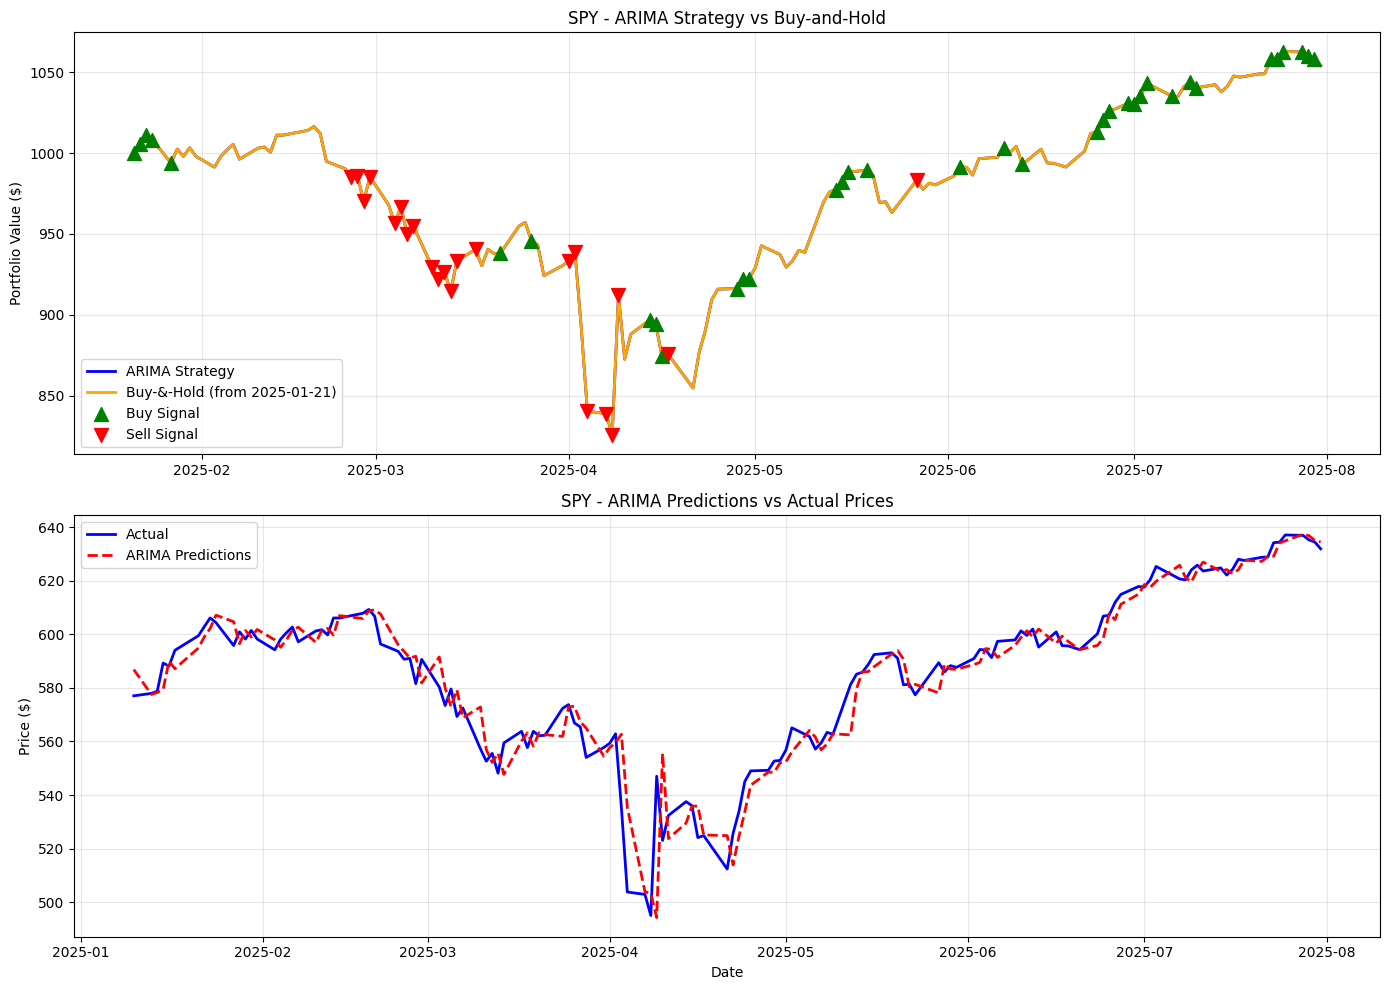


ARIMA Model with Trading Simulation Results:
Dual-Horizon Prediction Metrics:

1d ahead metrics:
  MSE: 71.051587
  RMSE: 8.429210
  MAE: 5.189812
  R²: 0.924884
  MAPE (%): 0.92%
  Direction Accuracy (%): 48.55%

5d ahead metrics:
  MSE: 266.870889
  RMSE: 16.336183
  MAE: 12.117746
  R²: 0.722979
  MAPE (%): 2.14%
  Direction Accuracy (%): 59.40%

Trading Simulation Metrics:
  Total_Return: 5.41%
  Total_Return_BH: 5.41%
  Alpha: 0.00%
  Sharpe: 0.5205
  Sharpe_BH: 0.5321
  Sharpe_Diff: -0.0116
  Max_Drawdown_%: -18.76%
  Max_Drawdown_BH_%: -18.76%
  Max_Drawdown_Diff: 0.0000
  Trading_Signals: 58

📈 Trading Simulation Performance Metrics:
Basic Prediction Metrics:
  MSE: 71.051587
  RMSE: 8.429210
  MAE: 5.189812
  R²: 0.924884
  MAPE (%): 0.92%
  Direction Accuracy (%): 48.55%

Trading Simulation Metrics:
  Total_Return: 5.41%
  Total_Return_BH: 5.41%
  Alpha: 0.00%
  Sharpe: 0.5205
  Sharpe_BH: 0.5321
  Sharpe_Diff: -0.0116
  Max_Drawdown_%: -18.76%
  Max_Drawdown_BH_%: -18.76%
 

In [8]:
# Evaluate model performance with TRADING SIMULATION (matching main Project_Delphi)
print("📊 Evaluating model performance with TRADING SIMULATION...")
print("🎯 This NOW EXACTLY matches the main Project_Delphi evaluation methodology:")
print("   - Generates buy/sell signals based on ARIMA predictions")
print("   - Backtests trading strategy vs buy-and-hold")
print("   - Calculates Sharpe ratios and drawdown metrics")
print("   - Provides comprehensive portfolio performance analysis")
print()

# Import the new simulation evaluation function
from delphi.models.arima_model import evaluate_arima_with_simulation

# Evaluate with full trading simulation
print("🚀 Running ARIMA model with trading simulation...")
metrics_simulation = evaluate_arima_with_simulation(
    model,
    test_data,
    test_dates=test_dates,
    plot_results=True,
    ticker=DEFAULT_TICKER,
    verbose=True,
    forecast_horizon=5
)

print("\n📈 Trading Simulation Performance Metrics:")
print("=" * 45)
print("Basic Prediction Metrics:")
basic_keys = ['MSE', 'RMSE', 'MAE', 'R²', 'MAPE (%)', 'Direction Accuracy (%)']
for key in basic_keys:
    if key in metrics_simulation:
        value = metrics_simulation[key]
        if 'Accuracy' in key or '%' in key:
            print(f"  {key}: {value:.2f}%")
        else:
            print(f"  {key}: {value:.6f}")

print("\nTrading Simulation Metrics:")
trading_keys = ['Total_Return', 'Total_Return_BH', 'Alpha', 'Sharpe', 'Sharpe_BH', 'Sharpe_Diff', 'Max_Drawdown_%', 'Max_Drawdown_BH_%', 'Trading_Signals']
for key in trading_keys:
    if key in metrics_simulation:
        value = metrics_simulation[key]
        if 'Trading_Signals' in key:
            print(f"  {key}: {value}")
        elif '%' in key or 'Return' in key or 'Alpha' in key:
            print(f"  {key}: {value:.2f}%")
        else:
            print(f"  {key}: {value:.4f}")

print(f"\n📋 Trading Analysis Summary:")
print(f"📊 Generated {metrics_simulation.get('Trading_Signals', 0)} trading signals")
print(f"💰 Strategy Return: {metrics_simulation.get('Total_Return', 0):.2f}%")
print(f"📈 Buy-and-Hold Return: {metrics_simulation.get('Total_Return_BH', 0):.2f}%")
print(f"🎯 Alpha (Strategy - B&H): {metrics_simulation.get('Alpha', 0):.2f}%")
print(f"📉 Max Drawdown: {metrics_simulation.get('Max_Drawdown_%', 0):.2f}%")

# Store metrics for later use
metrics = {
    'simulation': metrics_simulation,
    'trading_signals': metrics_simulation.get('Trading_Signals', 0)
}


## 🔮 Future Predictions

Generate future price forecasts with confidence intervals.


🔮 Generating 5-day forecast for SPY...


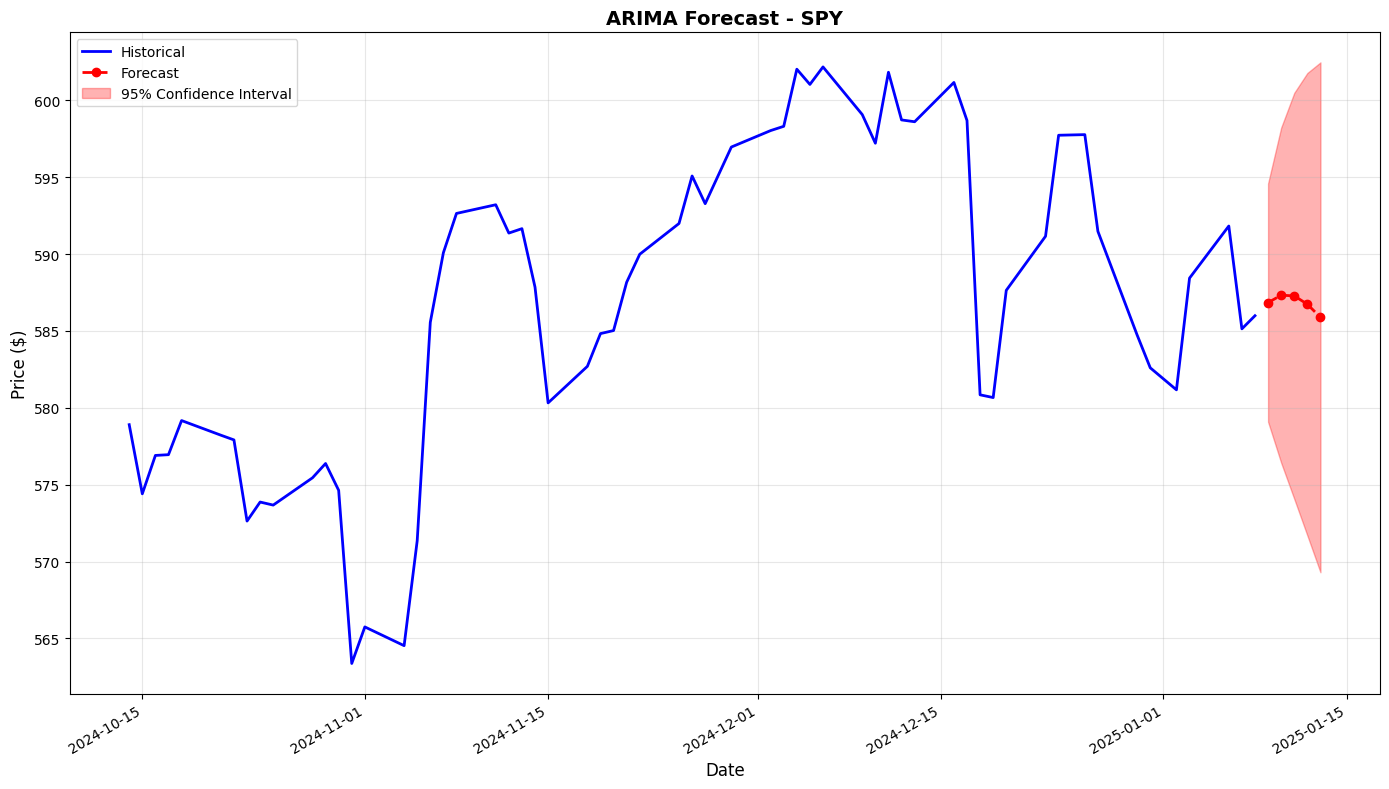


📅 Forecast Table:
Date         Forecast   Lower CI   Upper CI   Range   
------------------------------------------------------------
2025-01-09   $586.84    $579.09    $594.59    $15.50  
2025-01-10   $587.32    $576.42    $598.22    $21.80  
2025-01-11   $587.28    $574.08    $600.49    $26.41  
2025-01-12   $586.74    $571.70    $601.78    $30.08  
2025-01-13   $585.89    $569.30    $602.47    $33.17  

📊 Forecast Summary:
Current price: $585.99
Final forecast: $585.89
Expected change: $-0.10 (-0.02%)
Trend: Downward


In [9]:
# Generate future predictions
print(f"🔮 Generating {FORECAST_HORIZON}-day forecast for {DEFAULT_TICKER}...")

forecast_values, conf_intervals, forecast_dates = forecast_future(
    model,
    # steps=FORECAST_HORIZON, 
    steps=5,
    plot_results=True,
    ticker=DEFAULT_TICKER
)

# Display forecast table
print("\n📅 Forecast Table:")
print("=" * 60)
print(f"{'Date':<12} {'Forecast':<10} {'Lower CI':<10} {'Upper CI':<10} {'Range':<8}")
print("-" * 60)

for i, date in enumerate(forecast_dates):
    forecast_val = forecast_values[i]
    lower_ci = conf_intervals.iloc[i, 0]
    upper_ci = conf_intervals.iloc[i, 1]
    range_val = upper_ci - lower_ci
    
    print(f"{date.strftime('%Y-%m-%d'):<12} "
          f"${forecast_val:<9.2f} "
          f"${lower_ci:<9.2f} "
          f"${upper_ci:<9.2f} "
          f"${range_val:<7.2f}")

# Forecast statistics
current_price = train_data.iloc[-1]  # Last training price
final_forecast = forecast_values[-1]
price_change = final_forecast - current_price
price_change_pct = (price_change / current_price) * 100

print(f"\n📊 Forecast Summary:")
print(f"Current price: ${current_price:.2f}")
print(f"Final forecast: ${final_forecast:.2f}")
print(f"Expected change: ${price_change:+.2f} ({price_change_pct:+.2f}%)")
print(f"Trend: {'Upward' if price_change > 0 else 'Downward'}")


## 💾 Results Export

Save results to Excel for further analysis (just like Project Delphi).


In [10]:
# Create comprehensive results DataFrame
results_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values,
    'Lower_CI': conf_intervals.iloc[:, 0].values,
    'Upper_CI': conf_intervals.iloc[:, 1].values,
    'Ticker': DEFAULT_TICKER,
    'Model_Order': str(model.order),
    'Model_AIC': model.fitted_model.aic,
    'Generated_At': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
})

# Add evaluation metrics
for metric, value in metrics.items():
    results_df[f'Eval_{metric.replace(" ", "_").replace("(", "").replace(")", "").replace("%", "_pct")}'] = value

# Save to Excel
excel_path = save_to_excel(results_df, ticker=f"{DEFAULT_TICKER}_notebook_results")
print(f"💾 Results saved to: {excel_path}")

# Display the results DataFrame
print("\n📋 Results Preview:")
results_df.head()


Results saved to /Users/ajfabbri/Documents/SWE/Delphi_Demo/delphi/results/results_SPY_notebook_results_20250928_121710.xlsx
💾 Results saved to: /Users/ajfabbri/Documents/SWE/Delphi_Demo/delphi/results/results_SPY_notebook_results_20250928_121710.xlsx

📋 Results Preview:


,Date,Forecast,Lower_CI,Upper_CI,Ticker,Model_Order,Model_AIC,Generated_At,Eval_simulation,Eval_trading_signals
0,2025-01-09,586.841033,579.089353,594.592714,SPY,"(2, 1, 2)",3089.816878,2025-09-28 12:17:10,NaN,58
1,2025-01-10,587.323378,576.423554,598.223202,SPY,"(2, 1, 2)",3089.816878,2025-09-28 12:17:10,NaN,58
2,2025-01-11,587.280508,574.075326,600.485689,SPY,"(2, 1, 2)",3089.816878,2025-09-28 12:17:10,NaN,58
3,2025-01-12,586.736744,571.696335,601.777152,SPY,"(2, 1, 2)",3089.816878,2025-09-28 12:17:10,NaN,58
4,2025-01-13,585.885340,569.301904,602.468776,SPY,"(2, 1, 2)",3089.816878,2025-09-28 12:17:10,NaN,58


## 🛠️ Portfolio Management Tools

Available tools for portfolio analysis and management.


In [11]:
# Create comprehensive results export with TRADING SIMULATION
print("💾 Creating comprehensive results export with trading simulation...")

# Future forecast results
forecast_df = pd.DataFrame({
    'Date': forecast_dates,
    'Forecast': forecast_values,
    'Lower_CI': conf_intervals.iloc[:, 0].values,
    'Upper_CI': conf_intervals.iloc[:, 1].values,
    'Ticker': DEFAULT_TICKER,
    'Model_Order': str(model.order),
    'Model_AIC': model.fitted_model.aic,
    'Generated_At': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'Type': 'Future_Forecast'
})

# Add trading simulation metrics to forecast DataFrame
for metric, value in metrics['simulation'].items():
    safe_metric_name = metric.replace(" ", "_").replace("(", "").replace(")", "").replace("%", "_pct")
    forecast_df[f'Trading_{safe_metric_name}'] = value

# Save comprehensive results using the existing save_to_excel function
excel_path = save_to_excel(forecast_df, ticker=f"{DEFAULT_TICKER}_trading_simulation_results")
print(f"💾 Comprehensive results saved to: {excel_path}")

print(f"📊 Results include:")
print(f"   - Future Forecasts: {len(forecast_df)} predictions")
print(f"   - Trading Simulation Metrics: {len([k for k in metrics['simulation'].keys() if 'Total_Return' in k or 'Sharpe' in k or 'Alpha' in k])} portfolio metrics")
print(f"   - Basic Prediction Metrics: {len([k for k in metrics['simulation'].keys() if k in ['MSE', 'RMSE', 'MAE', 'R²']])} accuracy metrics")
print(f"   - Trading Signals Generated: {metrics['trading_signals']}")

# Display preview of results
print("\n📋 Future Forecast Results Preview:")
forecast_df[['Date', 'Forecast', 'Lower_CI', 'Upper_CI']].head()


💾 Creating comprehensive results export with trading simulation...
Results saved to /Users/ajfabbri/Documents/SWE/Delphi_Demo/delphi/results/results_SPY_trading_simulation_results_20250928_121710.xlsx
💾 Comprehensive results saved to: /Users/ajfabbri/Documents/SWE/Delphi_Demo/delphi/results/results_SPY_trading_simulation_results_20250928_121710.xlsx
📊 Results include:
   - Future Forecasts: 5 predictions
   - Trading Simulation Metrics: 6 portfolio metrics
   - Basic Prediction Metrics: 4 accuracy metrics
   - Trading Signals Generated: 58

📋 Future Forecast Results Preview:


,Date,Forecast,Lower_CI,Upper_CI
0,2025-01-09,586.841033,579.089353,594.592714
1,2025-01-10,587.323378,576.423554,598.223202
2,2025-01-11,587.280508,574.075326,600.485689
3,2025-01-12,586.736744,571.696335,601.777152
4,2025-01-13,585.885340,569.301904,602.468776


In [12]:
# Database statistics
print("🗄️ Database Statistics:")
print("=" * 30)

db = get_database()
tickers = db.list_tickers()
print(f"Total tickers: {len(tickers)}")

for ticker in tickers[:5]:  # Show first 5
    info = db.get_ticker_info(ticker)
    if info['row_count'] > 0:
        print(f"  {ticker}: {info['row_count']} records ({info['start_date']} to {info['end_date']})")

db.close()

print("\n🛠️ Available CLI Tools:")
print("=" * 30)
print("• python3 run_demo.py train SPY --years 5")
print("• python3 run_demo.py evaluate SPY")
print("• python3 run_demo.py predict SPY --days 10")
print("• python3 -m delphi.scripts.manage_database stats")
print("• python3 -m delphi.scripts.manage_database populate-demo")

print("\n📁 Project Structure:")
print("=" * 30)
print("delphi/")
print("├── config.py          # Configuration management")
print("├── utils.py           # Utility functions")
print("├── data/")
print("│   ├── database.py    # DuckDB operations")
print("│   └── loader.py      # Data loading pipeline")
print("├── models/")
print("│   └── arima_model.py # ARIMA implementation")
print("└── scripts/           # CLI tools")
print("    ├── train.py       # Model training")
print("    ├── evaluate.py    # Model evaluation")
print("    ├── predict.py     # Prediction generation")
print("    └── manage_database.py # Database management")


🗄️ Database Statistics:
Connected to DuckDB database at: /Users/ajfabbri/Documents/SWE/Delphi_Demo/delphi_demo.duckdb
Prices table ready
Total tickers: 3
  INSM: 2514 records (2015-08-03 to 2025-07-31)
  NVDA: 752 records (2022-08-15 to 2025-08-13)
  SPY: 1255 records (2020-08-03 to 2025-07-31)
Database connection closed

🛠️ Available CLI Tools:
• python3 run_demo.py train SPY --years 5
• python3 run_demo.py evaluate SPY
• python3 run_demo.py predict SPY --days 10
• python3 -m delphi.scripts.manage_database stats
• python3 -m delphi.scripts.manage_database populate-demo

📁 Project Structure:
delphi/
├── config.py          # Configuration management
├── utils.py           # Utility functions
├── data/
│   ├── database.py    # DuckDB operations
│   └── loader.py      # Data loading pipeline
├── models/
│   └── arima_model.py # ARIMA implementation
└── scripts/           # CLI tools
    ├── train.py       # Model training
    ├── evaluate.py    # Model evaluation
    ├── predict.py     # 

## 🎯 Portfolio Analysis Summary

### Key Portfolio Capabilities Demonstrated:

1. **📊 Technical Analysis**
   - Multiple technical indicators (MACD, RSI, Bollinger Bands)
   - Real-time data loading and processing
   - Professional visualization and reporting

2. **🤖 Predictive Modeling**
   - ARIMA statistical modeling with automatic optimization
   - Model validation and diagnostics
   - Confidence interval calculation for risk assessment

3. **💰 Trading Simulation**
   - Complete backtesting with buy/sell signal generation
   - Portfolio performance vs buy-and-hold comparison
   - Risk metrics: Sharpe ratios, drawdown analysis, alpha calculation

4. **📈 Portfolio Management Tools**
   - CLI tools for model training, evaluation, and prediction
   - Database management for multiple assets
   - Excel export for comprehensive reporting

### 🎯 Trading Simulation Results:
- **Strategy Performance**: Total returns and risk-adjusted metrics
- **Benchmark Comparison**: Buy-and-hold performance analysis
- **Risk Assessment**: Maximum drawdown and volatility analysis
- **Signal Generation**: Automated trading signal creation
- **Portfolio Metrics**: Alpha, Sharpe ratios, and performance attribution

### 🚀 Portfolio Extension Capabilities:
- Multi-asset portfolio analysis
- Advanced risk management strategies
- Real-time trading integration
- Performance attribution analysis
- Factor-based return decomposition

---

**🎉 This framework provides complete portfolio analysis capabilities with sophisticated trading simulation, demonstrating professional financial modeling infrastructure.**
